## Uporaba scikit-learn za klasifikacijo

## Using scikit-learn for classification

Knjižnica scikit-learn nudi funkcije za izdelavo klasifikacijskih modelov, njihovo ocenjevanje in točkovanje.

The library scikit-learn implements function for construction of classification models, their evaluation and scoring. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']
import matplotlib
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")

import matplotlib.pyplot as plt
plt.style.use('PR.mplstyle')

import pandas as pd
import sklearn
import numpy as np

### Učni algoritmi in klasifikatorji

### Learners and Classifiers

Klasifikacija uporablja dve vrsti objektov: učne algoritme in klasifikatorje. Učni lagoritmi
upoštevajo podatke, označene z razredom, in vrnejo klasifikator. Glede na prve tri podatkovne primere, klasifikatorji vrnejo indekse predvidenega razreda:

Classification uses two types of objects: learners and classifiers. Learners consider class-labeled data and return a classifier. Given the first three data instances, classifiers return the indexes of predicted class:

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_table("podatki/voting.tab", skiprows=[1,2])
#data.replace({'y': 1, 'n': 0}, inplace=True)
data.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [4]:
from sklearn import preprocessing

X = data.drop('party', axis=1).values
enc = preprocessing.OrdinalEncoder()
X = enc.fit_transform(X)
y = data['party'].values

Podatki vsebujejo neznane vrednosti. Preden lahko uporabimo učne algoritme, jih moramo zapolniti. Uporabimo imputator.

The data contains unknown values. Before we can use the learning algorithms, we need to fill them. We use an imputer.

In [5]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)
X

array([[0.        , 1.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.        , ..., 1.        , 0.        ,
        0.81268882],
       [0.44208038, 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.50387597, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 1.        , 0.        , ..., 1.        , 0.42751843,
        0.        ]])

In [6]:
clf = LogisticRegression()
model = clf.fit(X, y)

In [7]:
model.predict(X[:3])

array(['republican', 'republican', 'democrat'], dtype=object)

Zgoraj smo prebrali podatke, konstruirali logistično regresijo in mu dali podatkovni niz za izdelavo klasifikatorja ter ga uporabili za predvidevanje razreda prvih treh podatkovnih primerkov. Te koncepte uporabljamo tudi v naslednji kodi, ki napoveduje razrede izbranih treh primerkov v naboru podatkov:

Above, we read the data, constructed a logistic regression learner, gave it the dataset to construct a classifier, and used it to predict the class of the first three data instances. We also use these concepts in the following code that predicts the classes of the selected three instances in the dataset:

In [8]:
for i in range(5,8):
    c = model.predict(X[i].reshape(1, -1))
    print("{}, originally {}".format(c[0], y[i]))

democrat, originally democrat
republican, originally democrat
republican, originally republican


Logistična regresija je v drugem primeru naredila napako, sicer pa je napovedana pravilno. Ni čudno, saj so bili to tudi podatki, na katerih se je učila. Naslednja koda upošteva število takih napak v celotnem naboru podatkov:

Logistic regression has made a mistake in the second case, but otherwise predicted correctly. No wonder, since this was also the data it trained from. The following code counts the number of such mistakes in the entire dataset:

In [9]:
np.sum(y != model.predict(X))

12

To število nam ne pove dosti o natančnosti klasifikatorja. Prejšnji teden smo spoznali boljši način. 

This number does not tell us much about the accuracy of the classifier. Last week we learnt of a better way.

In [10]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y, model.predict(X)))

Accuracy: 0.9724137931034482


Če želite izvedeti, kakšna je verjetnost, da razvrščevalec dodeli, recimo, razred za demokrate, moramo klasifikator poklicati z drugačno funkcijo, ki vrne verjetnost za posamezen razred.

To find out what is the probability that the classifier assigns to, say, democrat class, we need to call the classifier with another function, that returns the probabilities for each class.

In [11]:
target_class = 0
print("Probabilities for %s:" % model.classes_[target_class])
for i in range(5,8):
    probabilities = model.predict_proba(X[i].reshape(1, -1))
    print("{}, originally {}".format(probabilities[0, target_class], y[i]))

Probabilities for democrat:
0.9825228000129097, originally democrat
0.16061789979173025, originally democrat
0.10249298023889775, originally republican


Scikit-learn vključuje različne klasifikacijske algoritme, med drugim:

* logistična regresija (`sklearn.linear_model.LogisticRegression`)
* k najbližjih sosedov (`sklearn.neighbors.KNeighborsClassifier`)
* support vector machines (npr. `sklearn.svm.SVC`)
* klasifikacijska drevesa (`sklearn.tree.DecisionTreeClassifier`)
* naključni gozd (`sklearn.ensemble.RandomForestClassifier`)

Nekatere od teh so vključene v kodo, ki ocenjuje verjetnost ciljnega razreda na preskusnih podatkih. Tokrat se podatki za učenje in testiranje razlikujejo:

Scikit-learn includes a variety of classification algorithms, including:

* logistic regression (`sklearn.linear_model.LogisticRegression`)
* k-nearest neighbors (`sklearn.neighbors.KNeighborsClassifier`)
* support vector machines (say, `sklearn.svm.SVC`)
* classification trees (`sklearn.tree.DecisionTreeClassifier`)
* random forest (`sklearn.ensemble.RandomForestClassifier`)

Some of these are included in the code that estimates the probability of a target class on a testing data. This time, training and test datasets are disjoint:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=5, random_state=42)

tree = DecisionTreeClassifier(max_depth=3)
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=0.1)

learners = [tree, knn, lr]
classifiers = [learner.fit(X_train, y_train) for learner in learners]

target = 0
print("Probabilities for %s:" % model.classes_[target])
print("original class ", " ".join("%-5s" % l.__class__.__name__ for l in classifiers))

c_values = model.classes_
for i in range(len(X_test)):
    print(("{:<15}" + " {:.3f}\t\t\t"*len(classifiers)).format(
        y_test[i],
        *(c.predict_proba(X_test[i].reshape(1, -1))[0, target] for c in classifiers)    
    ))

Probabilities for democrat:
original class  DecisionTreeClassifier KNeighborsClassifier LogisticRegression
democrat        1.000			 1.000			 0.876			
democrat        1.000			 1.000			 0.850			
republican      0.008			 0.000			 0.068			
republican      0.008			 0.000			 0.100			
republican      0.227			 0.000			 0.207			


##### Vprašanje 5-3-1
Preizkusi različne klasifikatorje. Kateri deluje najbolje na danih podatkih?

##### Question 5-3-1
Test different classifiers. Which works best on given data?

### Krivulja ROC in površina pod krivuljo (Area Under Curve - AUC)

### ROC curve and Area Under Curve (AUC)

Krivulja ROC je način, kako oceniti kvaliteto klasifikacije. Tipično na y os označimo delež resnično pozitivnih (TP rate) in na x os delež lažno pozitivnih (FP rate). Zgornji levi kot nam tako predstavlja idealni model brez lažno pozitivnih primerov in s 100% deležem resnično pozitivnih.

The ROC curve is a way to assess the quality of the classification. Typically, the y axis indicates true positive rate, and the x axis the false positive rate. The upper left corner represents an ideal model without false positives and with a 100% true positive rate.

In [13]:
data = pd.read_table('podatki/titanic-training.tab', skiprows=[1,2])
X = data.drop('survived', axis=1).values
y = data['survived'].values

enc = preprocessing.OrdinalEncoder()
X = enc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

learner = LogisticRegression()
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict_proba(X_test)

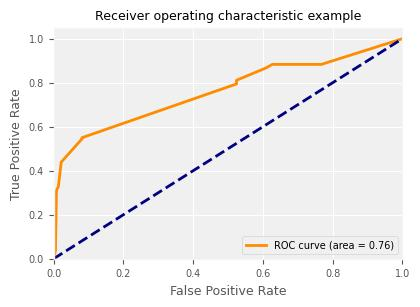

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, predictions[:,1], pos_label='yes')
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##### Vprašanje 5-3-2
Poišči modele z večjo površino pod krivuljo.

##### Question 5-3-2
Find models with a larger area under curve.

### Prečno preverjanje

### Cross-Validation

Ocenjevanje točnosti klasifikatorjev na učni množici, kot smo to storili zgoraj, služi samo za predstavitvene namene. Vsako mero natančnosti, je treba oceniti na neodvisni množici. Tak je tudi postopek, imenovan prečno preverjanje, ki povpreči vrednotenje po več izvajanjih, vsakič z drugačno učno in testno množico, ki so vzorčeni iz prvotnega nabora podatkov:

Validating the accuracy of classifiers on the training data, as we did above, serves demonstration purposes only. Any performance measure that assesses accuracy should be estimated on the independent test set. Such is also a procedure called cross-validation, which averages the evaluation scores across several runs, each time considering a different training and test subsets as sampled from the original dataset:

In [15]:
from sklearn.model_selection import cross_validate

learner = LogisticRegression()
scores = cross_validate(learner, X, y, cv=5, scoring=['accuracy', 'roc_auc'])

print("Accuracy: %.3f" % scores['test_accuracy'].mean())
print("AUC:      %.3f" % scores['test_roc_auc'].mean())

Accuracy: 0.784
AUC:      0.752


Z zgornjim prečnim preverjanjem lahko ocenimo samo enega učenca. Če želimo oceniti več učencev hkrati, moramo eksplicitno razdeliti podatke na učno in testno množico in za vsako razdelitev naučiti modele.

With the cross-validation above we can evaluate only one learner. If we want to evaluate multiple learners at the same time, we have to split the data and fit the models at each split.

Naslednja koda prečno preverja tri učence na zbirki podatkov titanic.

The following code cross-validates three learners on the titanic dataset.

In [16]:
from sklearn.model_selection import KFold
from collections import defaultdict

tree = DecisionTreeClassifier(max_depth=3)
knn = KNeighborsClassifier(n_neighbors=2)
lr = LogisticRegression(C=0.1)
classifiers = [tree, knn, lr]

acc = defaultdict(list)
aucs = defaultdict(list)

kf = KFold(n_splits=5)
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    for clf in classifiers:
        clf.fit(X_train, y_train)
        acc[clf].append(accuracy_score(y_test, clf.predict(X_test)))
        
        fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label='yes')
        aucs[clf].append(auc(fpr, tpr))
        
print(" "*9, " ".join("%-5s" % l.__class__.__name__ for l in classifiers))
print("Accuracy\t", "\t\t\t".join("%.2f" % np.array(acc[clf]).mean() for clf in classifiers))
print("AUC\t\t", "\t\t\t".join("%.2f" % np.array(aucs[clf]).mean() for clf in classifiers))

          DecisionTreeClassifier KNeighborsClassifier LogisticRegression
Accuracy	 0.80			0.78			0.78
AUC		 0.77			0.73			0.75


Seveda lahko tudi prečno preverimo učence istega tipa z različnimi parametri.

Of course, we can also cross-check learners of the same type with different parameters.

In [17]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors':[3, 5, 7]}
knn = KNeighborsClassifier()

clf = GridSearchCV(knn, parameters, scoring=['accuracy', 'roc_auc'], refit='accuracy')
clf.fit(X,y)
clf.cv_results_
print(" "*10 + " ".join("knn   "*3 ))
print("neighbors " + " ".join(" %i         " % i for i in [3, 5, 7]))
print("Accuracy  %s" % " ".join("%.2f       " % s for s in clf.cv_results_['mean_test_accuracy']))
print("AUC       %s" % " ".join("%.2f       " % s for s in clf.cv_results_['mean_test_roc_auc']))

          k n n       k n n       k n n      
neighbors  3           5           7         
Accuracy  0.75        0.75        0.76       
AUC       0.71        0.71        0.74       


##### Vprašanje 5-3-3
Izberi metodo klasificiranja in s prečnim preverjanjem testiraj različne vrednosti parametrov.

##### Question 5-3-3
Select a classifying method and use cross validation to evaluate different parameter values.